In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [3]:
!wget 'https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip'

--2020-04-14 15:07:25--  https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 2a00:1450:400c:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1388019404 (1.3G) [application/zip]
Saving to: ‘CASIA_ELA.zip’

CASIA_ELA.zip       100%[===================>]   1.29G   138MB/s    in 8.7s    

2020-04-14 15:07:34 (152 MB/s) - ‘CASIA_ELA.zip’ saved [1388019404/1388019404]



In [0]:
!unzip -o -q CASIA_ELA.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [6]:
path = Path("/home/tiago4k_gmail_com/CASIA_ELA"); path

PosixPath('/home/tiago4k_gmail_com/CASIA_ELA')

In [0]:
path_to_test = Path("/home/tiago4k_gmail_com/CASIA_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 28
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = tfms, size=size, bs=bs)
data.normalize(imagenet_stats)

data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [12]:
learn = cnn_learner(data, models.resnet101, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/tiago4k_gmail_com/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [13]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', 
                                                     monitor='accuracy', 
                                                     name='ela-1')])
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.368921,0.278160,0.917607,0.082392,03:48
1,0.281158,0.252962,0.914245,0.085755,03:42
2,0.237452,0.161317,0.928177,0.071823,03:41
3,0.193897,0.206501,0.913524,0.086476,03:41
4,0.156035,0.143913,0.945232,0.054768,03:41
5,0.135855,0.144780,0.948114,0.051886,03:41
6,0.118067,0.120594,0.950276,0.049724,03:41
7,0.110347,0.116496,0.955321,0.044679,03:41
8,0.109294,0.113091,0.956041,0.043959,03:41
9,0.109409,0.110444,0.955801,0.044199,03:41


In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

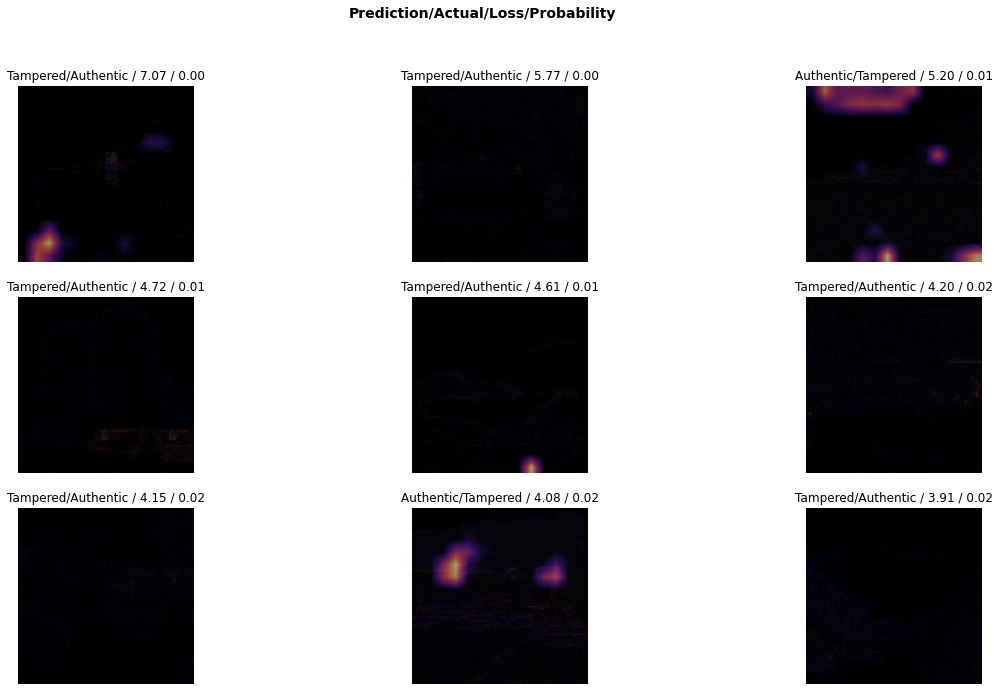

In [15]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

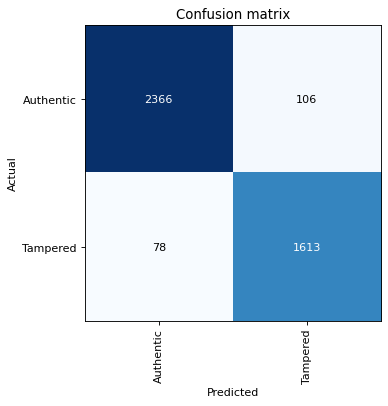

In [17]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


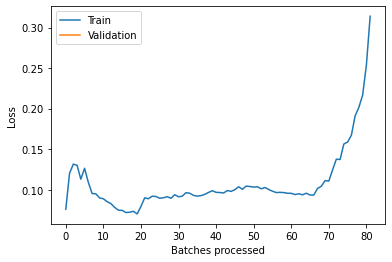

In [20]:
learn.recorder.plot_losses()

Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


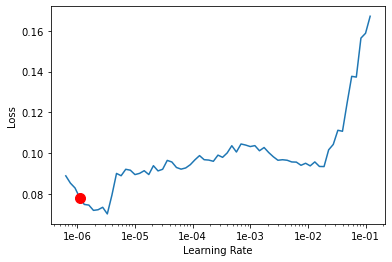

In [19]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


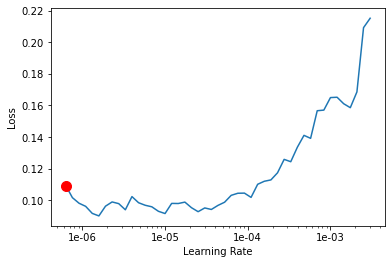

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(18, max_lr=slice(1e-6,1e-7))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.111631,0.112370,0.956522,0.043478,03:42
1,0.111711,0.111605,0.957002,0.042998,03:42
2,0.105906,0.112736,0.957002,0.042998,03:42
3,0.101388,0.111928,0.956041,0.043959,03:42
4,0.107745,0.111895,0.956282,0.043718,03:42
5,0.110185,0.112140,0.954600,0.045400,03:42
6,0.109574,0.112387,0.954840,0.045160,03:42
7,0.107099,0.111813,0.957002,0.042998,03:42
8,0.106035,0.112665,0.957483,0.042517,03:42
9,0.103350,0.111629,0.955080,0.044920,03:42


In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

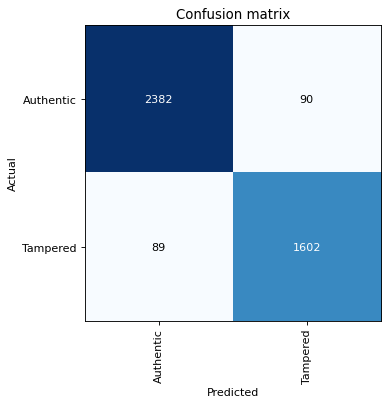

In [23]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.10E-07


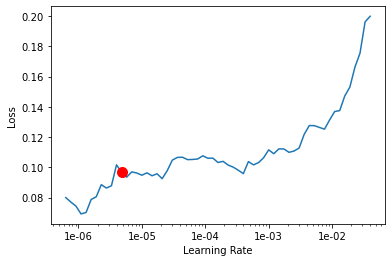

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-6))
learn.save('stage-3')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.096291,0.113517,0.956041,0.043959,04:43
1,0.111910,0.112091,0.956522,0.043478,04:41
2,0.105880,0.110083,0.957723,0.042277,04:41
3,0.107637,0.112137,0.955561,0.044439,04:41
4,0.103126,0.113282,0.956282,0.043718,04:41


Get Predictions and accuracy on the test dataset

In [35]:
learn.load('/home/tiago4k_gmail_com/CASIA_ELA/models/stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (7605 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /home/tiago4k_gmail_com/CASIA_ELA;

Valid: LabelList (4163 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /home/tiago4k_gmail_com/CASIA_ELA;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batc

In [36]:
path = '/home/tiago4k_gmail_com/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/home/tiago4k_gmail_com/CASIA_ELA/Test/Tampered/
/home/tiago4k_gmail_com/CASIA_ELA/Test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [38]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
476/502. Accuracy = 94.82%
Images Classified As Tampered
326/344. Accuracy = 94.77%


In [39]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 95.852%


In [0]:
learn.export()

Predict on a single image

In [0]:
img = open_image('/home/tiago4k_gmail_com/text_fake.JPG')
pred_class,pred_idx,confidence = learn.predict(img); pred_class

Category Authentic